# Bidirectional LSTM (Right Wrist)

##### https://www.kaggle.com/malekzadeh/human-activity-recognition-with-mobile-sensing

##### https://github.com/akhuperkar/HAR-Smartphone-Accelerometer/blob/master/HAR%20Using%20Machine%20Learning%20.ipynb

#### Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.stats
import math

import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import seaborn as sns
from tensorflow import keras

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split

from collections import defaultdict, Counter

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('gyr_data_right_wrist.csv')
df = df.drop([0])

In [3]:
print(df)

     PacketCounter  SampleTimeFine      Gyr_X     Gyr_Y      Gyr_Z Unnamed: 11
1                1      1255232210  12.263809 -0.726019 -17.096363            
2                2      1255248877   5.177547  0.610038 -22.477610            
3                3      1255265544  -1.303011  2.630488 -26.364588            
4                4      1255282211  -4.977266  4.914535 -28.234817            
5                5      1255298878  -9.409168  6.516964 -30.414976            
..             ...             ...        ...       ...        ...         ...
398            398      1261849009   5.708789  3.674296  -2.771999            
399            399      1261865676   4.133288  2.490323  -1.187142            
400            400      1261882343   3.316972  1.362468  -0.302223            
401            401      1261899010   2.882152  0.117953  -0.026919            
402            402      1261915677   3.271004 -0.885060   0.743581            

[402 rows x 6 columns]


In [4]:
df2 = pd.read_csv('gyr_data_right_wrist_label.csv')
df2 = df2.drop([0])
print(df2)

     PacketCounter  SampleTimeFine  Label
1                1      1255232210      1
2                2      1255248877      1
3                3      1255265544      1
4                4      1255282211      1
5                5      1255298878      1
..             ...             ...    ...
398            398      1261849009      3
399            399      1261865676      3
400            400      1261882343      3
401            401      1261899010      3
402            402      1261915677      3

[402 rows x 3 columns]


In [6]:
df_train = df
label_train = df2
print("Shape of original data:", df_train.shape)
print("Shape of labels data:", label_train.shape)

Shape of original data: (402, 6)
Shape of labels data: (402, 3)


In [7]:
print(df_train.head())

   PacketCounter  SampleTimeFine      Gyr_X     Gyr_Y      Gyr_Z Unnamed: 11
1              1      1255232210  12.263809 -0.726019 -17.096363            
2              2      1255248877   5.177547  0.610038 -22.477610            
3              3      1255265544  -1.303011  2.630488 -26.364588            
4              4      1255282211  -4.977266  4.914535 -28.234817            
5              5      1255298878  -9.409168  6.516964 -30.414976            


In [8]:
def magnitude(activity):
    x2 = activity['Gyr_X'] * activity['Gyr_X']
    y2 = activity['Gyr_Y'] * activity['Gyr_Y']
    z2 = activity['Gyr_Z'] * activity['Gyr_Z']
    m2 = x2 + y2 + z2
    m = m2.apply(lambda x: math.sqrt(x))
    return m

df_train['m'] = magnitude(df_train)
df_train.head()

,PacketCounter,SampleTimeFine,Gyr_X,Gyr_Y,Gyr_Z,Unnamed: 11,m
1,1,1255232210,12.263809,-0.726019,-17.096363,,21.052642
2,2,1255248877,5.177547,0.610038,-22.477610,,23.074273
3,3,1255265544,-1.303011,2.630488,-26.364588,,26.527510
4,4,1255282211,-4.977266,4.914535,-28.234817,,29.088327
5,5,1255298878,-9.409168,6.516964,-30.414976,,32.497293


In [9]:
print(label_train.head())

   PacketCounter  SampleTimeFine  Label
1              1      1255232210      1
2              2      1255248877      1
3              3      1255265544      1
4              4      1255282211      1
5              5      1255298878      1


In [10]:
pd.DataFrame.from_dict(Counter(label_train['Label']), orient="Index", columns=['label']).reset_index()

,index,label
0,1,121
1,2,127
2,3,154


#### Plot Acceleration Data

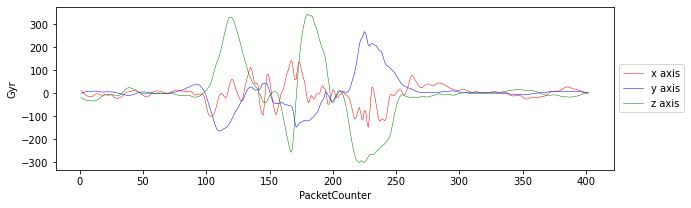

In [11]:
plt.figure(figsize=(10,3))
plt.plot(df_train['PacketCounter'], df_train['Gyr_X'], linewidth=0.5, color='r', label='x axis')
plt.plot(df_train['PacketCounter'], df_train['Gyr_Y'], linewidth=0.5, color='b', label='y axis')
plt.plot(df_train['PacketCounter'], df_train['Gyr_Z'], linewidth=0.5, color='g', label='z axis')
plt.xlabel('PacketCounter')
plt.ylabel('Gyr')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

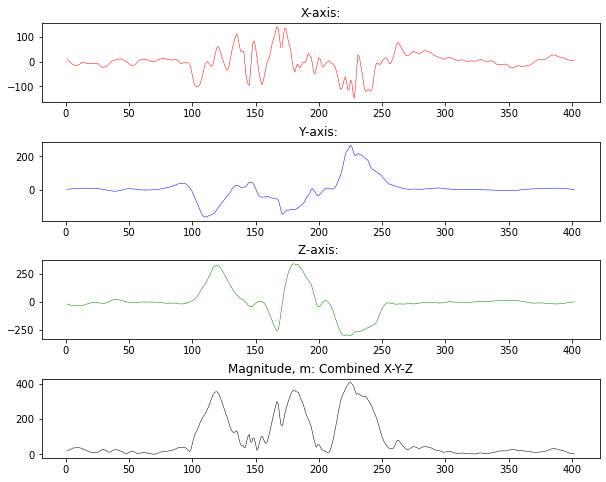

In [12]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10,8))

ax[0].set_title('X-axis:')
ax[0].plot(df_train['PacketCounter'], df_train['Gyr_X'], linewidth=0.5, color='r')

ax[1].set_title('Y-axis: ')
ax[1].plot(df_train['PacketCounter'], df_train['Gyr_Y'], linewidth=0.5, color='b')

ax[2].set_title('Z-axis: ')
ax[2].plot(df_train['PacketCounter'], df_train['Gyr_Z'], linewidth=0.5, color='g')

ax[3].set_title('Magnitude, m: Combined X-Y-Z')
ax[3].plot(df_train['PacketCounter'], df_train['m'], linewidth=0.5, color='k')

fig.subplots_adjust(hspace=.5)

In [14]:
# Separating data for each activity
train_df = pd.concat([df_train, label_train['Label']], axis=1).dropna()
columns = ['PacketCounter', 'Gyr_X', 'Gyr_Y', 'Gyr_Z', 'm', 'Label']

idle = train_df[columns][train_df.Label == 1]
waack = train_df[columns][train_df.Label == 2]
wrist_on_elbow = train_df[columns][train_df.Label == 3]

In [15]:
wrist_on_elbow.head()

,PacketCounter,Gyr_X,Gyr_Y,Gyr_Z,m,Label
249,249,-8.962578,87.369560,-86.098282,122.990577,3
250,250,0.576594,78.986862,-61.385826,100.037376,3
251,251,7.326230,69.258179,-42.335625,81.502602,3
252,252,13.184861,59.779140,-26.451519,66.686348,3
253,253,15.456020,51.498135,-16.024084,56.104525,3


In [16]:
waack.head()

,PacketCounter,Gyr_X,Gyr_Y,Gyr_Z,m,Label
122,122,42.043419,-91.959190,309.075531,325.195058,2
123,123,24.752884,-80.789124,293.916840,305.821347,2
124,124,8.085079,-72.326698,275.449921,284.902051,2
125,125,-6.428979,-64.825363,254.924103,263.115864,2
126,126,-19.808086,-53.674900,235.394196,242.247358,2


In [17]:
idle.head()

,PacketCounter,Gyr_X,Gyr_Y,Gyr_Z,m,Label
1,1,12.263809,-0.726019,-17.096363,21.052642,1
2,2,5.177547,0.610038,-22.477610,23.074273,1
3,3,-1.303011,2.630488,-26.364588,26.527510,1
4,4,-4.977266,4.914535,-28.234817,29.088327,1
5,5,-9.409168,6.516964,-30.414976,32.497293,1


#### Plot Activity Data

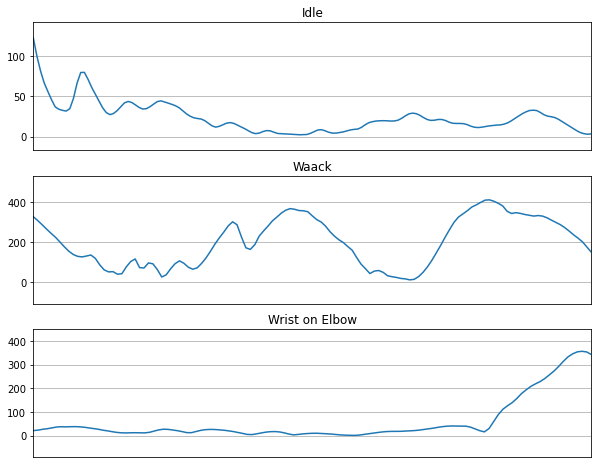

In [18]:
def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
def plot_activity(activities, titles):
    fig, axs = plt.subplots(nrows=len(activities), figsize=(10, 8))
    for i in range(0, len(activities)):
        plot_axis(axs[i], activities[i]['PacketCounter'], activities[i]['m'], titles[i])
    plt.subplots_adjust(hspace=0.2)
    plt.show()

plot_activity([wrist_on_elbow, waack, idle],
              ['Idle', 'Waack', 'Wrist on Elbow'])

#### Split training data

In [19]:
X_train, X_test, y_train, y_test = train_test_split(train_df, label_train, test_size = 0.2, random_state = 0)

In [20]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (321, 8)
y_train shape: (321, 3)


In [21]:
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_test shape: (81, 8)
y_test shape: (81, 3)


In [22]:
def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = label_train['Label'].iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 300 #400 #200 #300
STEP = 150  #100 #60 #80 #40 #150

X_train, y_train = create_dataset(
    df[['Gyr_X', 'Gyr_Y', 'Gyr_Z']], 
    TIME_STEPS, 
    STEP
)

X_test, y_test = create_dataset(
    df[['Gyr_X', 'Gyr_Y', 'Gyr_Z']], 
    TIME_STEPS, 
    STEP
)

In [23]:
print(X_train.shape, y_train.shape)

(252, 150, 3) (252, 1)


In [24]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

In [25]:
print(X_train.shape, y_train.shape)

(252, 150, 3) (252, 3)


#### Train the model

In [26]:
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X_train.shape[0], X_train.shape[1]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [27]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64, #64 #128 #32
    validation_split=0.1,
    shuffle=True
)

Train on 226 samples, validate on 26 samples
Epoch 1/20
226/226 [==============================] - 4s 16ms/sample - loss: 1.0882 - acc: 0.4558 - val_loss: 1.1704 - val_acc: 0.0000e+00
Epoch 2/20
226/226 [==============================] - 1s 4ms/sample - loss: 0.5152 - acc: 0.8584 - val_loss: 1.5711 - val_acc: 0.0000e+00
Epoch 3/20
226/226 [==============================] - 1s 4ms/sample - loss: 0.2829 - acc: 0.9336 - val_loss: 1.8964 - val_acc: 0.0000e+00
Epoch 4/20
226/226 [==============================] - 1s 4ms/sample - loss: 0.1908 - acc: 0.9469 - val_loss: 2.0314 - val_acc: 0.0385
Epoch 5/20
226/226 [==============================] - 1s 4ms/sample - loss: 0.0924 - acc: 0.9912 - val_loss: 2.0304 - val_acc: 0.1154
Epoch 6/20
226/226 [==============================] - 1s 4ms/sample - loss: 0.0626 - acc: 0.9912 - val_loss: 2.1250 - val_acc: 0.1538
Epoch 7/20
226/226 [==============================] - 1s 4ms/sample - loss: 0.0474 - acc: 0.9867 - val_loss: 2.2709 - val_acc: 0.1538
Epoc

#### Evaluation

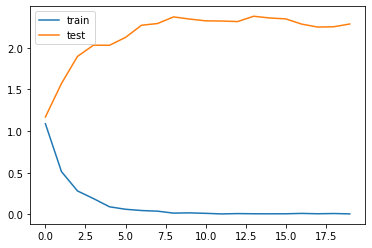

In [28]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

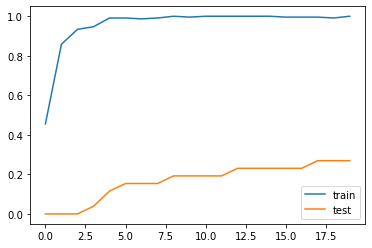

In [29]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend();

In [30]:
model.evaluate(X_test, y_test)

252/252 [==============================] - 0s 772us/sample - loss: 0.2377 - acc: 0.9246


[0.2377275353083239, 0.92460316]

In [31]:
model.evaluate(X_train, y_train)

252/252 [==============================] - 0s 879us/sample - loss: 0.2377 - acc: 0.9246


[0.2377275353083239, 0.92460316]

#### Confusion Matrix

In [35]:
y_pred = model.predict(X_test)

In [36]:
column_names = 'Idle', 'Waack', 'Wrist_on_Elbow'

def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(18, 16)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(column_names)
  ax.set_yticklabels(column_names)
  b, t = plt.ylim() # discover the values for bottom and top
  #b += 0.5 # Add 0.5 to the bottom
  #t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() # ta-da!

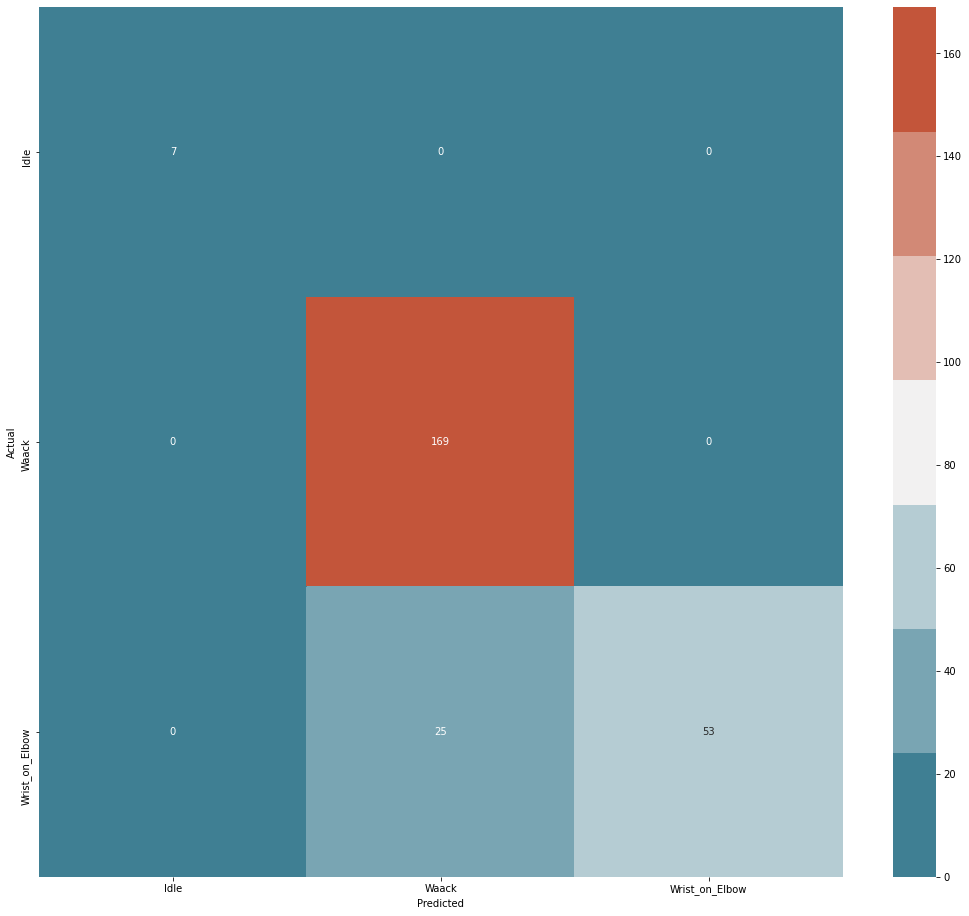

In [37]:
plot_cm(
  enc.inverse_transform(y_test),
  enc.inverse_transform(y_pred),
  enc.categories_[0]
)